In [3]:
import sys
import math
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

from Src import augment_image, \
        show_multiple_images_in_tf_dataset, \
        split_and_prepare_datasets
from config import CLASSES_LIST
from tensorflow.keras.applications import EfficientNetB0

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sibi_train_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_train_dataset.tfrecord", compression="GZIP")
sibi_test_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_test_dataset.tfrecord", compression="GZIP")

In [5]:
print(f'info train data: {sibi_train_dataset_loaded}')
print(f'number of train data: {len(sibi_train_dataset_loaded)}')
print()
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of train data: 5200

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [6]:
sibi_train_dataset_augmented = sibi_train_dataset_loaded.map(augment_image)
sibi_train_dataset_cached = sibi_train_dataset_augmented.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 1)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.1727062612771988

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: P
    label-shape: (26,)
    image-type: <dtype: 'float32'>


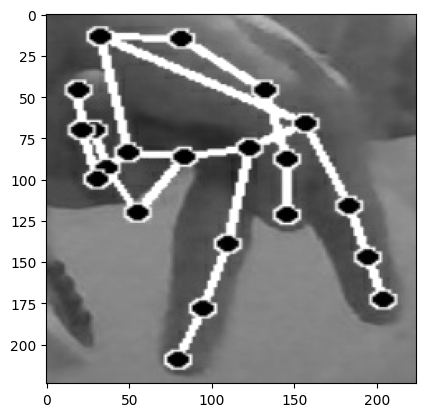

In [7]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_cached.shuffle(buffer_size=sibi_train_dataset_cached.cardinality().numpy()).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

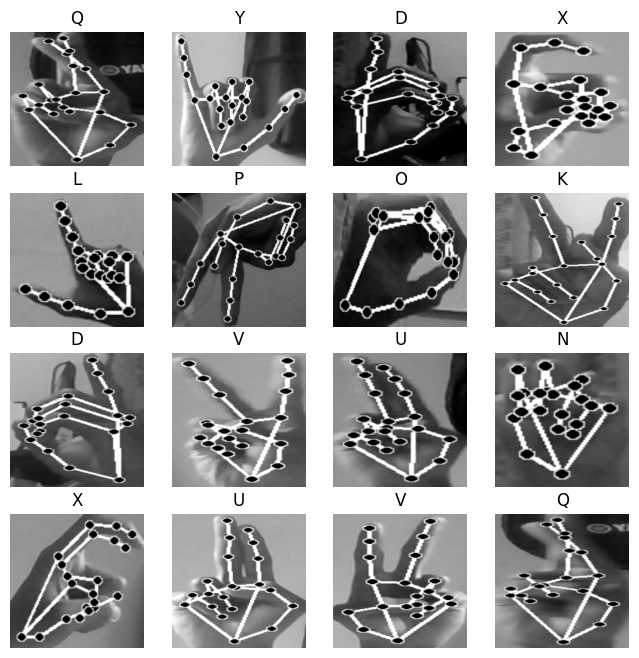

In [8]:
show_multiple_images_in_tf_dataset(sibi_train_dataset_cached, num_images=16, classes_list=CLASSES_LIST)

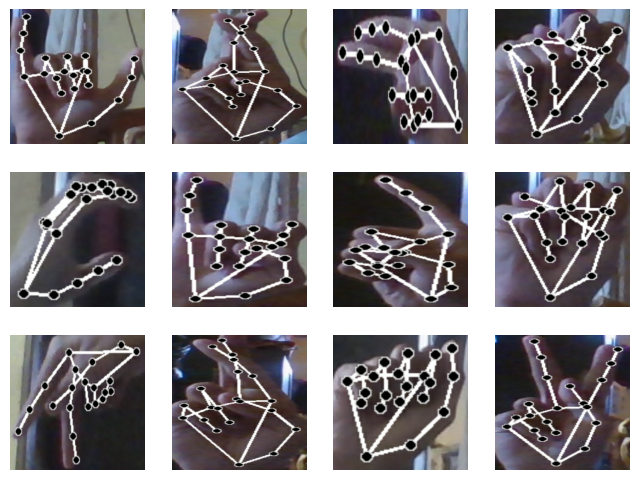

In [9]:
show_multiple_images_in_tf_dataset(sibi_test_dataset_loaded, num_images=12)

In [10]:
train_dataset_batched, valid_dataset_batched = split_and_prepare_datasets(sibi_train_dataset_cached, batch_size=32, train_split=0.9)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Training Split: 0.9
Number of data: 4680
AFTER BATCH: 32
Number of data: 147
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Validation Split: 0.1
Number of data: 520
AFTER BATCH: 32
Number of data: 17


In [11]:
def convert_to_rgb(image, label):
    # Ulangi channel 1 kali untuk mendapatkan 3 channel (grayscale ke RGB)
    image_rgb = tf.image.grayscale_to_rgb(image)
    return image_rgb, label

In [12]:
sibi_train_dataset_rgb = train_dataset_batched.map(convert_to_rgb)
sibi_valid_dataset_rgb = valid_dataset_batched.map(convert_to_rgb)

sibi_train_dataset_rgb_cached = sibi_train_dataset_rgb.cache()
sibi_valid_dataset_rgb_cached = sibi_valid_dataset_rgb.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: D
    label-shape: (26,)
    image-type: <dtype: 'float32'>


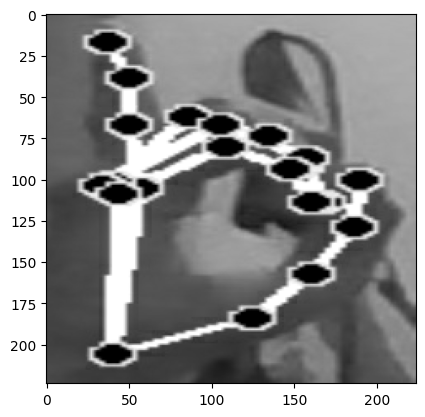

In [15]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_rgb.shuffle(buffer_size=sibi_train_dataset_rgb.cardinality().numpy()).take(1):
    image, label = image[0], label[0]
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

In [14]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [16]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [18]:
# Arsitektur ML-ResNet
def build_model(input_shape=(224, 224, 3), num_classes=None, base_model_trainable=False):
    input_layer = tf.keras.Input(shape=input_shape)

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = base_model_trainable

    # Pass the input through the base model
    x = base_model(input_layer, training=False)
    
    # Add global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Add fully connected tf.keras.layers with dropout
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer with softmax activation
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    learning_rate_adam = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
    )

    # Compile the model
    model.compile(optimizer=learning_rate_adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_model(input_shape=(224, 224, 3), num_classes=len(CLASSES_LIST), base_model_trainable=False)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,774,461 (18.21 MB)

 Trainable params: 724,890 (2.77 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
target_path_keras_model = '../Assets/Model/SIBI_effecientnetb0_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=target_path_keras_model,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=50,
  restore_best_weights=True,
  verbose=1
)

history = model.fit(
    sibi_train_dataset_rgb_cached,
    validation_data=sibi_valid_dataset_rgb_cached,
    epochs=250,
    callbacks=[
    plateau_callback,
    early_stopping,
    # checkpoint_callback
  ]
)